## Train classifier by layers

This notebook trains a classifier that operates in two layers:
- First we use a SVM classifier to label utterances with high degree of certainty.
- Afterwards we use heuristics to complete the labeling

### Import and path definition

In [1]:
import os
import pandas as pd
import numpy as np
import random
import pickle
import sys
import matplotlib.pyplot as plt

root_path = os.path.dirname(os.path.dirname(os.path.abspath(os.getcwd())))
sys.path.append(root_path)

from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from src import phase_classification as pc

data_path = os.path.join(root_path,'data')
tables_path = os.path.join(data_path,'tables')

### Load data

In [2]:
WITH_STEMMING = True
#REMOVE_STOPWORDS = True
SEED = 10
NUM_TOPICS = 60
random.seed(SEED)

In [3]:
file_name = '[train]IBL_topic_distribution_by_utterance_with_phrase_before_and_after_time_utterance_minimum_0_words_with_stemming_{}_{}.xlsx'.format(WITH_STEMMING,NUM_TOPICS)
df_data = pd.read_excel(os.path.join(tables_path,'train',file_name))

In [4]:
df_data.head()

,Topic before 1,Topic before 2,Topic before 3,Topic before 4,Topic before 5,Topic before 6,Topic before 7,Topic before 8,Topic before 9,Topic before 10,...,Topic after 60,phase,phase_1,phase_2,phase_3,phase_4,phase_5,utterance,length utterance,utterance_relative_time
0,0.009546,0.012683,0.006349,0.005774,0.003684,0.005008,0.004698,0.008680,0.012694,0.015815,...,0.008342,1,1,0,0,0,0,SATUNNAINEN,0.000000,0.000000
1,0.009546,0.012683,0.006349,0.005774,0.003684,0.005008,0.004698,0.008680,0.012694,0.015815,...,0.008342,1,1,0,0,0,0,siel QUESTION_SYMBOL onks oo palo,0.065574,0.010417
2,0.102342,0.009047,0.004529,0.004119,0.002628,0.003573,0.003351,0.006192,0.009057,0.011282,...,0.007004,1,1,0,0,0,0,no tää varm muutu,0.049180,0.017361
3,0.102352,0.009047,0.004529,0.004119,0.002628,0.003573,0.003351,0.006192,0.009055,0.011303,...,0.004486,1,1,0,0,0,0,aja T_ ATOMI ehtiny törm ton ver,0.098361,0.020833
4,0.005717,0.007596,0.003803,0.077523,0.002207,0.003000,0.002814,0.005199,0.007603,0.009472,...,0.013502,1,1,0,0,0,0,ton ver ai pitä muute kato sil taas oo lask to...,0.213115,0.027778


In [5]:
the_keys = list(set(df_data['phase']))
total_samples = 0
class_samples = {}
for key in the_keys:
    n = list(df_data.phase.values).count(key)
    #print("key {}, total {}".format(key,n))
    total_samples += n
    class_samples[key] = n
print(total_samples)
for key in the_keys:
    print("key {}, samples: {}, prop: {}".format(key,class_samples[key],round(class_samples[key]*1.0/total_samples,2)))

1600
key 1, samples: 403, prop: 0.25
key 2, samples: 175, prop: 0.11
key 3, samples: 406, prop: 0.25
key 4, samples: 62, prop: 0.04
key 5, samples: 554, prop: 0.35


### split data

In [9]:
filter_rows = list(range(1,181))+[188,189]
filter_labels = [181]

In [10]:
train_set,validation_set = pc.split_df(df_data,0.2)
X_train,y_train = pc.get_data_from_dict(train_set,filter_rows)
X_val,y_val = pc.get_data_from_dict(validation_set,filter_rows)

validation set phase 1: 80
validation set phase 2: 35
validation set phase 3: 81
validation set phase 4: 12
validation set phase 5: 110


In [12]:
len(X_train[0])

182

In [13]:
all_set,_ = pc.split_df(df_data,0.0)
X_all,y_all = pc.get_data_from_dict(all_set,filter_rows)

validation set phase 1: 0
validation set phase 2: 0
validation set phase 3: 0
validation set phase 4: 0
validation set phase 5: 0


### Classify first layer

In [14]:
len(X_train[0])

182

In [15]:
class_weight = {}
for key in the_keys:
    class_weight[key] = 1000.0/class_samples[key]

In [16]:
svc = SVC(kernel='linear',random_state=SEED,max_iter=3000,probability=True)#,class_weight=class_weight)
svc.fit(X_train, y_train)
print('Accuracy of SVM classifier on training set: {:.2f}'
     .format(svc.score(X_train, y_train)))
print('Accuracy of SVM classifier on test set: {:.2f}'
     .format(svc.score(X_val, y_val)))

Accuracy of SVM classifier on training set: 0.54
Accuracy of SVM classifier on test set: 0.53


In [17]:
pred = svc.predict(X_val)
labels = ["Phase {}".format(i) for i in range(1,6)]
df = pd.DataFrame(confusion_matrix(y_val, pred),columns=["Predicted {}".format(i) for i in labels])
df.index = labels
#print(" ")
print(classification_report(y_val, pred))
df

              precision    recall  f1-score   support

           1       0.50      0.64      0.56        80
           2       0.00      0.00      0.00        35
           3       0.70      0.41      0.52        81
           4       0.00      0.00      0.00        12
           5       0.49      0.75      0.59       110

   micro avg       0.53      0.53      0.53       318
   macro avg       0.34      0.36      0.33       318
weighted avg       0.47      0.53      0.48       318



C:\Users\CATALINA ESPINOZA\AppData\Local\conda\conda\envs\teacher_topic_model\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


,Predicted Phase 1,Predicted Phase 2,Predicted Phase 3,Predicted Phase 4,Predicted Phase 5
Phase 1,51,0,4,0,25
Phase 2,8,0,1,0,26
Phase 3,23,0,33,0,25
Phase 4,0,0,1,0,11
Phase 5,19,0,8,0,83


### Find threshold

Look for the distance to the second max

In [18]:
pred_val = svc.predict_proba(X_val)
prob_pred = [v[int(y_val[i]-1)] for i,v in enumerate(pred_val)]

(array([42., 51., 32., 34., 45., 40., 46., 21.,  3.,  4.]),
 array([0.03324997, 0.12805379, 0.22285761, 0.31766142, 0.41246524,
        0.50726906, 0.60207288, 0.6968767 , 0.79168051, 0.88648433,
        0.98128815]),
 <a list of 10 Patch objects>)

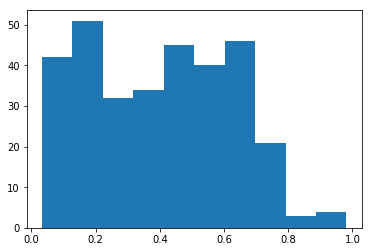

In [19]:
plt.hist(prob_pred)

In [20]:
tuple_winner_pred = [(np.max(v),prob_pred[i],np.max(v)==prob_pred[i]) for i,v in enumerate(pred_val)]
values_ok = [v[0] for i,v in enumerate(tuple_winner_pred) if v[2]==True]
values_not_ok = [v[0] for i,v in enumerate(tuple_winner_pred) if v[2]==False]
values_dist_not_ok = [v[0]-v[1] for i,v in enumerate(tuple_winner_pred) if v[2]==False]

(array([ 0.,  1.,  6., 21., 21., 25., 22., 17., 12.,  7.,  2.,  3.,  0.,
         0.]),
 array([0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55, 0.6 , 0.65, 0.7 ,
        0.75, 0.8 , 0.85, 0.9 ]),
 <a list of 14 Patch objects>)

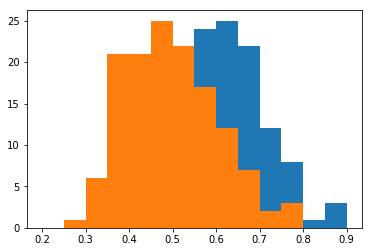

In [21]:
plt.hist(values_ok,np.arange(0.2,.95,.05))
plt.hist(values_not_ok,np.arange(0.2,.95,.05))

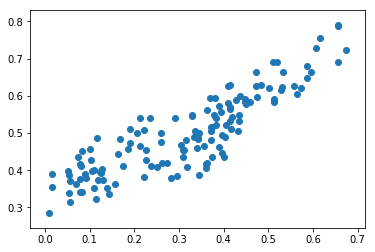

In [22]:
plt.scatter(values_dist_not_ok,values_not_ok)

Define Threshold 

In [23]:
t = 0.65

In [24]:
df_data.columns

Index(['Topic before 1', 'Topic before 2', 'Topic before 3', 'Topic before 4',
       'Topic before 5', 'Topic before 6', 'Topic before 7', 'Topic before 8',
       'Topic before 9', 'Topic before 10',
       ...
       'Topic after 60', 'phase', 'phase_1', 'phase_2', 'phase_3', 'phase_4',
       'phase_5', 'utterance', 'length utterance', 'utterance_relative_time'],
      dtype='object', length=189)

In [25]:
output_first_layer = pc.first_layer_classifier(X_all,t,svc)
comparison = list(zip(output_first_layer,y_all))

In [26]:
df_data['first_layer'] = output_first_layer

### Second layer

In [32]:
import importlib
importlib.reload(pc)

<module 'src.phase_classification' from 'C:\\Users\\CATALINA ESPINOZA\\Documents\\ciae\\Classification_IBL\\src\\phase_classification.py'>

In [127]:
len(svc.coef_)
svc.classes_
svc.n_support_

array([255, 140, 298,  50, 389])

In [27]:
second_layer,coeff = pc.second_layer_combination_before_after(X_all,df_data,svc)

In [37]:
svc

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=3000, probability=True, random_state=10,
  shrinking=True, tol=0.001, verbose=False)

In [43]:
from scipy.optimize import minimize


In [116]:
phases = df_data.phase.values
s,v1,v2,v3 = pc.get_linear_system(X_all,svc,phases)

In [117]:
sol,As = pc.get_solution_linear_system(s,v1,v2,v3)

In [118]:
As,bs = pc.get_elements_linear_system(s,v1,v2,v3)
fun = lambda x: np.sum([np.linalg.norm(np.dot(As[i],x)-bs[i]) for i in range(len(s))])
cons = ({'type': 'eq', 'fun': lambda x:  x[0]+x[1]+x[2]-1})
sol = minimize(fun, np.zeros(3), method='SLSQP', bounds=[(0.,1) for x in range(3)],constraints=cons)
sol.x

array([0.50014077, 0.1612038 , 0.33865542])

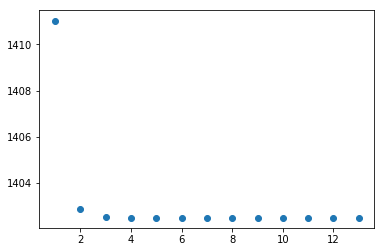

In [120]:
x = range(1,14)
y = []
for i in range(1,14):
    sol = minimize(fun, np.zeros(3), method='SLSQP', bounds=[(0.,1) for x in range(3)],constraints=cons,options={'maxiter':i})
    y.append(fun(sol.x))
plt.scatter(x,y)

In [121]:
fun([0,1,0])

1412.9734118155675

In [122]:
fun(sol.x)

1402.509558583298

In [28]:
df_data['second_layer'] = second_layer

In [29]:
df = pd.DataFrame(confusion_matrix(y_all, second_layer),columns=["Predicted {}".format(i) for i in labels])
df.index = labels
print(classification_report(y_all, second_layer))
df

              precision    recall  f1-score   support

           1       0.58      0.72      0.65       403
           2       0.87      0.31      0.46       175
           3       0.76      0.56      0.65       406
           4       1.00      0.05      0.09        62
           5       0.57      0.76      0.65       554

   micro avg       0.62      0.62      0.62      1600
   macro avg       0.76      0.48      0.50      1600
weighted avg       0.67      0.62      0.61      1600



,Predicted Phase 1,Predicted Phase 2,Predicted Phase 3,Predicted Phase 4,Predicted Phase 5
Phase 1,290,6,21,0,86
Phase 2,45,54,4,0,72
Phase 3,73,1,228,0,104
Phase 4,0,0,4,3,55
Phase 5,88,1,43,0,422


In [30]:
with open(os.path.join(data_path,'classifier_svm_linear_combination_svc_ba.pickle'),'wb') as f:
    pickle.dump(svc,f)
    pickle.dump(coeff,f)

In [31]:
df_data.to_excel(os.path.join(tables_path,'[second_layer]'+file_name))